<a href="https://colab.research.google.com/github/EloneSampaio/SkinVisionAI/blob/master/FeatureExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classe Base

#### https://iqbalpa.medium.com/easily-image-data-preparation-with-imagedatagenerator-in-tensorflow-5fd75fb32bc2

#### https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

#### https://huggingface.co/google/vit-base-patch16-224

# Função para Carregar Imagens Organizadas em Pastas de Classes

# Monte o Google Drive

#Carregar as imagens

In [14]:
class BaseExtractor:
    def preprocess_images(self, images):
        raise NotImplementedError("Subclasses must implement this method.")

    def extract_features(self, images, labels=None):
        raise NotImplementedError("Subclasses must implement this method.")


# CNNFeatureExtractor

In [15]:
import tensorflow as tf
from google.colab import drive
import os
from PIL import Image
import numpy as np

class CNNFeatureExtractor(BaseExtractor):
    def __init__(self, model_name='VGG16', input_shape=(224, 224, 3)):
        self.model_name = model_name
        self.input_shape = input_shape
        self.model = self._load_model()

    def _load_model(self):
        if self.model_name == 'VGG16':
            return tf.keras.applications.VGG16(include_top=False, input_shape=self.input_shape, pooling='avg')
        elif self.model_name == 'ResNet50':
            return tf.keras.applications.ResNet50(include_top=False, input_shape=self.input_shape, pooling='avg')
        raise ValueError("Unsupported CNN model.")

    def preprocess_images(self, images):
        if self.model_name == 'VGG16':
            return tf.keras.applications.vgg16.preprocess_input(images)
        elif self.model_name == 'ResNet50':
            return tf.keras.applications.resnet50.preprocess_input(images)

    def extract_features(self, images, labels=None):
        images = self.preprocess_images(images)
        return self.model.predict(images, verbose=1)


# ViTFeatureExtractor


In [16]:
from transformers import AutoImageProcessor, AutoModel, ViTImageProcessorFast,AutoFeatureExtractor
from transformers import AutoConfig

# Verifique se a GPU está ativa
import torch
print(torch.cuda.is_available())  # Deve retornar True

class ViTFeatureExtractor(BaseExtractor):
    def __init__(self, model_name='google/vit-base-patch16-224'):
        self.model_name = model_name
        if 'vit' in model_name:
              self.processor = ViTImageProcessorFast.from_pretrained(self.model_name, use_fast=True)
        elif 'deit' in model_name:
             self.processor = AutoFeatureExtractor.from_pretrained(self.model_name)
        else:
            pass
        self.config = AutoConfig.from_pretrained(self.model_name, torch_dtype=torch.float16)
        self.model = AutoModel.from_pretrained(self.model_name, config=self.config)



    def preprocess_images(self, images):
        return self.processor(images=images, return_tensors="pt")

    def extract_features(self, images, labels=None, batch_size=8):
          """
          Extrai características processando as imagens em lotes para evitar problemas de memória.
          Args:
              images (np.ndarray): Imagens para extração.
              labels (np.ndarray): Rótulos correspondentes (opcional).
              batch_size (int): Tamanho do lote para processamento.
          Returns:
              np.ndarray: Características extraídas.
          """
          features = []
          for i in range(0, len(images), batch_size):
              batch_images = images[i:i + batch_size]
              inputs = self.preprocess_images(batch_images)
              outputs = self.model(**inputs)
              batch_features = outputs.last_hidden_state[:, 0, :].detach().numpy()  # Token [CLS]
              features.append(batch_features)
          return np.vstack(features)


False


# FeatureExtractorFactory

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

class FeatureExtractorFactory:
    @staticmethod
    def create_extractor(model_name, input_shape=(224, 224, 3)):
        if model_name in ['VGG16', 'ResNet50', 'EfficientNetB0']:
            return CNNFeatureExtractor(model_name, input_shape)
        elif 'vit' in model_name or 'facebook':
            return ViTFeatureExtractor(model_name)
        else:
            raise ValueError(f"Model {model_name} is not supported.")

    @staticmethod
    def split_data(images, labels, test_size=0.2, random_state=42):
        """
        Divide o conjunto de dados em treinamento e teste.
        Args:
            images (np.ndarray): Imagens do dataset.
            labels (np.ndarray): Rótulos correspondentes.
            test_size (float): Proporção de dados para teste.
            random_state (int): Semente para reprodutibilidade.
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        return train_test_split(images, labels, test_size=test_size, stratify=labels, random_state=random_state)

    @staticmethod
    def extract_and_save(extractor, images, labels=None, file_name='features.npz'):
        """
        Extrai características e salva em um arquivo .npz.
        Args:
            extractor (BaseExtractor): Instância do extrator.
            images (np.ndarray): Imagens para extração.
            labels (np.ndarray): Rótulos correspondentes (opcional).
            file_name (str): Nome do arquivo de saída.
        """
        features = extractor.extract_features(images)
        np.savez(file_name, features=features, labels=labels)
        print(f"Características salvas em {file_name}")
        return features

    @staticmethod
    def load_images_with_labels(base_folder, image_size=(224, 224)):
        """
        Carrega imagens organizadas por classes em subpastas.
        Args:
            base_folder (str): Caminho para a pasta geral contendo subpastas de classes.
            image_size (tuple): Dimensão para redimensionar as imagens.
        Returns:
            tuple: (X, y, class_names)
        """
        images = []
        labels = []
        class_names = sorted(os.listdir(base_folder))  # Lista de classes (subpastas)

        for class_idx, class_name in enumerate(class_names):
            class_folder = os.path.join(base_folder, class_name)
            if os.path.isdir(class_folder):
                for file_name in os.listdir(class_folder):
                    file_path = os.path.join(class_folder, file_name)
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg','.bmp')) and "_" not in file_name.lower():
                        try:
                            # Abrir e redimensionar a imagem
                            with Image.open(file_path) as img:
                                img_resized = img.resize(image_size)
                                img_array = np.array(img_resized)
                                images.append(img_array)
                                labels.append(class_idx)
                            print(f"Imagem {file_name} da classe '{class_name}' carregada com sucesso.")
                        except Exception as e:
                            print(f"Erro ao carregar a imagem {file_name}: {e}")

        return np.array(images), np.array(labels), class_names

    def augment_data(self, X, y, batch_size=32, augmentation_config=None):
        """
        Wrapper para DataProcessor.augment_data.
        """
        return self.data_processor.augment_data(X, y, batch_size, augmentation_config)

    def balance_classes(self, X, y):
        """
        Wrapper para DataProcessor.balance_classes.
        """
        return self.data_processor.balance_classes(X, y)

    def normalize_features(self, X):
        """
        Wrapper para DataProcessor.normalize_features.
        """
        return self.data_processor.normalize_features(X)

    def reduce_dimensionality(self, X, variance_threshold=0.95):
        """
        Wrapper para DataProcessor.reduce_dimensionality.
        """
        return self.data_processor.reduce_dimensionality(X, variance_threshold)




#  Classe para avaliação de características extraídas

   **Resumo**
   
  Para avaliar a qualidade das características sem classificação:

  1. Visualize os dados no espaço reduzido: Use PCA ou t-SNE.
  2. Analise variância e entropia: Verifique a diversidade nas características.
  3. Calcule distâncias intra/inter-classes: Garanta que os dados estão bem separados.
  4. Cheque correlações: Identifique redundâncias.
  5. Interprete mapas de ativação: Para entender o que o modelo está aprendendo.

# Funcionalidades
1. Visualizações: PCA e t-SNE para entender a separação no espaço das características.
2. Métricas Estatísticas: Variância e entropia para medir a diversidade das características.
3. Distâncias: Mede a separação intra e inter-classe.
4. Correlação: Identifica redundâncias entre características.
5. Relatório Consolidado: Um resumo completo das métricas e visualizações.
A classe permite uma análise robusta e completa da qualidade das características extraídas.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import entropy
from scipy.spatial.distance import cdist
import seaborn as sns

class FeatureEvaluator:
    def __init__(self, features, labels):
        """
        Inicializa a classe de avaliação com as características e os rótulos.
        Args:
            features (np.ndarray): Características extraídas (forma: [n_samples, n_features]).
            labels (np.ndarray): Rótulos correspondentes às características.
        """
        self.features = features
        self.labels = labels

    def visualize_pca(self, n_components=2):
        """
        Visualiza as características reduzidas com PCA.
        Args:
            n_components (int): Número de componentes a reduzir (default: 2).
        """
        pca = PCA(n_components=n_components)
        reduced_features = pca.fit_transform(self.features)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.labels, cmap='viridis', alpha=0.7)
        plt.title('PCA das Características')
        plt.colorbar(label="Classe")
        plt.show()

    def visualize_tsne(self, n_components=2, perplexity=30, random_state=42):
        """
        Visualiza as características reduzidas com t-SNE.
        Args:
            n_components (int): Número de componentes a reduzir (default: 2).
            perplexity (int): Perplexidade para o t-SNE (default: 30).
            random_state (int): Semente para reprodutibilidade (default: 42).
        """
        tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
        reduced_features = tsne.fit_transform(self.features)
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=self.labels, cmap='viridis', alpha=0.7)
        plt.title('t-SNE das Características')
        plt.colorbar(label="Classe")
        plt.show()



    def calculate_variance(self):
        """
        Calcula a variância de cada característica.
        Returns:
            np.ndarray: Variâncias das características.
        """
        variances = np.var(self.features, axis=0)
        print(f"Variância média das características: {np.mean(variances):.4f}")
        return variances

    def calculate_entropy(self):
        """
        Calcula a entropia de cada característica.
        Returns:
            np.ndarray: Entropias das características.
        """
        feature_entropies = [entropy(np.histogram(f, bins=10, density=True)[0]) for f in self.features.T]
        print(f"Entropia média das características: {np.mean(feature_entropies):.4f}")
        return feature_entropies

    def calculate_variance_inter_and_intra_and_separability(self):
      """
      Calcula as variâncias médias intra-classe e inter-classe.
      Returns:
        tuple: Variância média intra-classe e inter-classe.
      """
      intra_class_variance = []
      class_centroids = {}

      # Calcular variância intra-classe e guardar os centroides
      for class_label in np.unique(self.labels):
          # Filtrar as características da classe atual
          class_features = self.features[self.labels == class_label]

          # Variância intra-classe
          intra_variance = np.var(class_features, axis=0)
          intra_class_variance.append(np.mean(intra_variance))

          # Centroide da classe
          class_centroids[class_label] = np.mean(class_features, axis=0)

      # Calcular variância inter-classe com os centroides
      centroids = np.array(list(class_centroids.values()))
      centroid_variance = np.var(centroids, axis=0)
      variance_inter_mean = np.mean(centroid_variance)

      # Variância intra-classe média
      variance_intra_mean = np.mean(intra_class_variance)
      # Índice de separabilidade
      separability = variance_inter_mean / variance_intra_mean

      print(f"Variância média intra-classe: {variance_intra_mean:.4f}")
      print(f"Variância média inter-classe: {variance_inter_mean:.4f}")
      print(f"Índice de separabilidade: {separability:.4f}")
      return variance_intra_mean, variance_inter_mean,separability


    def calculate_distances(self):
        """
        Calcula as distâncias médias intra-classe e inter-classe.
        Returns:
            tuple: Distância média intra-classe, distância média inter-classe.
        """
        intra_class_dists = []
        inter_class_dists = []

        for class_label in np.unique(self.labels):
            # Distâncias intra-classe
            class_features = self.features[self.labels == class_label]
            intra_dists = cdist(class_features, class_features, metric='euclidean')
            intra_class_dists.append(np.mean(intra_dists))

            # Distâncias inter-classe
            other_features = self.features[self.labels != class_label]
            inter_dists = cdist(class_features, other_features, metric='euclidean')
            inter_class_dists.append(np.mean(inter_dists))

        intra_mean = np.mean(intra_class_dists)
        inter_mean = np.mean(inter_class_dists)
        print(f"Distância média intra-classe: {intra_mean:.4f}")
        print(f"Distância média inter-classe: {inter_mean:.4f}")
        return intra_mean, inter_mean

    def visualize_correlations(self):
        """
        Visualiza a matriz de correlação entre as características.
        """
        correlation_matrix = np.corrcoef(self.features, rowvar=False)
        sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
        plt.title('Matriz de Correlação entre Características')
        plt.show()

    def generate_report(self):
        """
        Gera um relatório com todas as métricas e visualizações.
        """
        print("=== Relatório de Avaliação das Características ===")
        print("1. Variância das Características:")
        variances = self.calculate_variance()
        print("2. Entropia das Características:")
        entropies = self.calculate_entropy()
        print("3. Distâncias Intra e Inter-Classe:")
        intra_dist, inter_dist = self.calculate_distances()
        print("4. Variância Média Intra-Classe , Inter-Classe e Separabilidade:")
        intra_variance, inter_variance,J = self.calculate_variance_inter_and_intra_and_separability()
        print("5. Matriz de Correlação:")
        self.visualize_correlations()
        print("6. Visualizações:")
        self.visualize_pca()
        self.visualize_tsne()


# Classe DataProcessor
Classe que encapsula funcionalidades como:
  1. Data Augmentation
  2. Balanceamento de Classes,
  3. Normalização e Pré-Processamento
  4. Redução de Dimensionalidade.

In [19]:
!pip install tensorflow

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator



import numpy as np

class DataProcessor:
    def __init__(self):
        """
        Inicializa o processador de dados com configurações padrão.
        """
        self.scaler = StandardScaler()
        self.pca = None

    def augment_data(self, X, y, batch_size=32, desired_samples=500,augmentation_config=None, num_batches=None):
        """
        Realiza data augmentation em imagens, com opção de gerar todos os dados.
        Args:
            X (np.ndarray): Imagens em formato NumPy.
            y (np.ndarray): Rótulos correspondentes.
            batch_size (int): Tamanho do lote para augmentação.
            desired_samples (int): Número total de amostras desejado.
            augmentation_config (dict): Configurações para o ImageDataGenerator.
            num_batches (int): Número de lotes a serem gerados. Se None, itera até o fim dos dados.

        Returns:
            tuple: Imagens aumentadas (np.ndarray) e rótulos (np.ndarray).
        """
        if augmentation_config is None:
            augmentation_config = {
                "rotation_range": 20,
                "width_shift_range": 0.2,
                "height_shift_range": 0.2,
                "horizontal_flip": True,
                "brightness_range": [0.8, 1.2]
            }

        # Configurar o gerador
        datagen = ImageDataGenerator(**augmentation_config)
        augmented_data = datagen.flow(X, y, batch_size=batch_size)
        print(f"Data augmentation configurado com batch size {batch_size}.")

        # Gerar e armazenar todos os lotes
        X_augmented = []
        y_augmented = []


        if num_batches is None:
            # Calcular o número total de lotes para cobrir todos os dados
            num_batches = len(X) // batch_size + (len(X) % batch_size != 0)

        for _ in range(desired_samples // batch_size):
            X_batch, y_batch = next(augmented_data)
            X_augmented.append(X_batch)
            y_augmented.append(y_batch)

        # Concatenar todos os lotes em arrays únicos
        X_augmented = np.concatenate(X_augmented, axis=0)
        y_augmented = np.concatenate(y_augmented, axis=0)

        return X_augmented, y_augmented


    def balance_classes(self, X, y):
        """
        Realiza oversampling para balancear as classes.
        Args:
            X (np.ndarray): Características ou imagens.
            y (np.ndarray): Rótulos correspondentes.
        Returns:
            tuple: (X_resampled, y_resampled)
        """
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X.reshape(len(X), -1), y)
        print(f"Dados balanceados: {np.bincount(y_resampled)}")
        return X_resampled.reshape(-1, *X.shape[1:]), y_resampled

    def normalize_features(self, X):
        """
        Normaliza as características para zero-mean e unit-variance.
        Aceita dados em 2D ou 4D (imagens).
        Args:
            X (np.ndarray): Características extraídas ou imagens.
        Returns:
            np.ndarray: Características normalizadas.
        """
        if len(X.shape) == 4:  # Imagens no formato [n_samples, height, width, channels]
            original_shape = X.shape
            X = X.reshape(X.shape[0], -1)  # Achatar para [n_samples, n_features]

        X_normalized = self.scaler.fit_transform(X)  # Normalização

        if len(original_shape) == 4:
            X_normalized = X_normalized.reshape(original_shape)  # Voltar ao formato original

        print("Características normalizadas (zero-mean, unit-variance).")
        return X_normalized


    def reduce_dimensionality(self, X, variance_threshold=0.95):
        """
        Reduz a dimensionalidade das características usando PCA.
        Args:
            X (np.ndarray): Características extraídas.
            variance_threshold (float): Porcentagem da variância a ser retida.
        Returns:
            np.ndarray: Características reduzidas.
        """
        self.pca = PCA(n_components=variance_threshold)
        X_reduced = self.pca.fit_transform(X)
        print(f"Redução de dimensionalidade concluída: {X_reduced.shape[1]} componentes retidos.")
        return X_reduced

    def inverse_transform_pca(self, X_reduced):
        """
        Reconstrói características reduzidas ao espaço original.
        Args:
            X_reduced (np.ndarray): Características reduzidas.
        Returns:
            np.ndarray: Características no espaço original.
        """
        if self.pca is None:
            raise ValueError("PCA não foi aplicado anteriormente.")
        return self.pca.inverse_transform(X_reduced)


# Classe DataPipeline

a classe  pipeline é estruturada para que cada etapa seja aplicada sequencialmente, com avaliações das métricas de separabilidade após cada transformação.

In [140]:
import numpy as np


class DataPipeline:
    '''
    Args:
       processor: Instância da classe DataProcessor
    '''
    def __init__(self, processor):
          self.processor = processor

    def run_pipeline(self, X, y, batch_size,desired_samples,augment_images=False, reduce_dimensionality= False, augmentation_config=None):
        """
        Executa o pipeline completo para melhorar as métricas de separabilidade.

        Args:
            X (np.ndarray): Características ou imagens originais.
            y (np.ndarray): Rótulos correspondentes.
            batch_size (int): Tamanho do lote para aumento de dados.
            desired_samples (int): Número total de amostras desejado.
            augment_images (bool): Indica se data augmentation será aplicada.
            augmentation_config (dict): Configurações para data augmentation (se aplicável).

        Returns:
            tuple: Características processadas, rótulos e métricas calculadas.
        """
        print("Iniciando pipeline de processamento de dados...")

        # 1. Balancear classes
        print("\n== Etapa 1: Balanceamento de classes == e Shape =")
        X_balanced, y_balanced = self.processor.balance_classes(X, y)
        print(f"Dados balanceados Shape: {np.shape(X_balanced)}") # formato retornado: [n_samples, height, width, channels]

        # 2. Normalizar características
        print("\n== Etapa 2: Normalização de características ==")
        X_normalized = self.processor.normalize_features(X_balanced)

        # 3. Aumentar dados (se imagens)
        if augment_images:
            print("\n== Etapa 3: Data augmentation ==")
            X_augmented, y_augmented = self.processor.augment_data(
                X_balanced, y_balanced,batch_size, desired_samples, augmentation_config=augmentation_config
            )
            #X_augmented, y_augmented = next(augmented_data)  # Pega um lote de dados aumentados
            print(f"Dados aumentados Shape: {np.shape(X_augmented)}")
        else:
            X_augmented, y_augmented = X_normalized, y_balanced
            print(f"Dados não aumentados Shape: {np.shape(X_augmented)}")

        # 4. Reduzir dimensionalidade
        if reduce_dimensionality:
            print("\n== Etapa 4: Redução de dimensionalidade ==")
            X_reduced = self.processor.reduce_dimensionality(X_augmented, variance_threshold=0.95)
        else:
            X_reduced = X_augmented

        return X_reduced, y_augmented


# Ferramentas para Extração e Processamento de Características(PT)


Este repositório fornece uma estrutura modular para extrair, processar e avaliar características de imagens, utilizando modelos pré-treinados como CNNs (e.g., VGG16, ResNet) e Vision Transformers (ViTs). Inclui:

1. **FeatureExtractorFactory**: Uma fábrica para criar e gerenciar extratores de características.
2. **DataProcessor**: Uma classe utilitária para pré-processamento, aumento de dados, balanceamento e redução de dimensionalidade.
3. **FeatureEvaluator**: Uma ferramenta para analisar e avaliar a qualidade das características extraídas.

---

## **Visão Geral das Classes**

### **1. FeatureExtractorFactory**
Esta classe lida com:
- Carregamento de imagens organizadas em pastas de classes.
- Divisão de dados em conjuntos de treinamento e teste.
- Gerenciamento de extração de características com modelos pré-treinados.

#### **Métodos**
- `create_extractor(model_name, input_shape=(224, 224, 3))`
  - **Descrição**: Cria um extrator de características para um modelo especificado (CNN ou ViT).
  - **Args**:
    - `model_name (str)`: Nome do modelo pré-treinado (e.g., `VGG16`, `google/vit-base-patch16-224`).
    - `input_shape (tuple)`: Dimensões de entrada para o modelo (padrão: `(224, 224, 3)`).
  - **Retorna**: Instância de um extrator de características (CNN ou ViT).

- `load_images_with_labels(base_folder, image_size=(224, 224))`
  - **Descrição**: Carrega imagens e seus respectivos rótulos de uma pasta estruturada por subpastas de classe.
  - **Args**:
    - `base_folder (str)`: Caminho para a pasta principal contendo as subpastas de classes.
    - `image_size (tuple)`: Tamanho para redimensionar imagens (padrão: `(224, 224)`).
  - **Retorna**: Tupla `(X, y, class_names)` onde `X` é o array de imagens, `y` são os rótulos e `class_names` são os nomes das classes.

- `split_data(images, labels, test_size=0.2, random_state=42)`
  - **Descrição**: Divide o conjunto de dados em treinamento e teste.
  - **Args**:
    - `images (np.ndarray)`: Conjunto de imagens.
    - `labels (np.ndarray)`: Rótulos correspondentes.
    - `test_size (float)`: Proporção de dados para teste (padrão: `0.2`).
    - `random_state (int)`: Semente para reprodutibilidade (padrão: `42`).
  - **Retorna**: Tupla `(X_train, X_test, y_train, y_test)`.

- `extract_and_save(extractor, images, labels=None, file_name='features.npz')`
  - **Descrição**: Extrai características usando o extrator fornecido e as salva em um arquivo `.npz`.
  - **Args**:
    - `extractor (BaseExtractor)`: Uma instância do extrator de características.
    - `images (np.ndarray)`: Imagens para extração de características.
    - `labels (np.ndarray)`: Rótulos correspondentes (opcional).
    - `file_name (str)`: Nome do arquivo de saída (padrão: `features.npz`).
  - **Retorna**: Características extraídas como um array NumPy.

---

### **2. DataProcessor**
Esta classe fornece utilitários para pré-processamento de dados, aumento de dados, balanceamento, normalização e redução de dimensionalidade.

#### **Métodos**
- `augment_data(X, y, batch_size=32, augmentation_config=None)`
  - **Descrição**: Aplica aumento de dados ao dataset.
  - **Args**:
    - `X (np.ndarray)`: Dados de imagem.
    - `y (np.ndarray)`: Rótulos correspondentes.
    - `batch_size (int)`: Tamanho do lote para aumento (padrão: `32`).
    - `augmentation_config (dict)`: Configurações para o ImageDataGenerator (padrão: rotação, flip, brilho).
  - **Retorna**: Gerador de dados com imagens aumentadas.

- `balance_classes(X, y)`
  - **Descrição**: Balanceia o conjunto de dados realizando oversampling em classes minoritárias.
  - **Args**:
    - `X (np.ndarray)`: Dados de imagem ou características.
    - `y (np.ndarray)`: Rótulos correspondentes.
  - **Retorna**: Dados balanceados `(X_resampled, y_resampled)`.

- `normalize_features(X)`
  - **Descrição**: Normaliza as características para média zero e variância unitária.
  - **Args**:
    - `X (np.ndarray)`: Dados de características.
  - **Retorna**: Características normalizadas.

- `reduce_dimensionality(X, variance_threshold=0.95)`
  - **Descrição**: Reduz a dimensionalidade das características usando PCA.
  - **Args**:
    - `X (np.ndarray)`: Dados de características.
    - `variance_threshold (float)`: Porcentagem da variância a ser retida (padrão: `0.95`).
  - **Retorna**: Conjunto reduzido de características.

---

### **3. FeatureEvaluator**
Esta classe avalia a qualidade das características extraídas usando métricas e visualizações.

#### **Métodos**
- `visualize_pca(n_components=2)`
  - **Descrição**: Visualiza características em 2D usando PCA.

- `visualize_tsne(n_components=2, perplexity=30)`
  - **Descrição**: Visualiza características em 2D usando t-SNE.

- `calculate_variance()`
  - **Descrição**: Calcula a variância de cada característica.

- `calculate_entropy()`
  - **Descrição**: Calcula a entropia de cada característica.

- `calculate_distances()`
  - **Descrição**: Calcula distâncias intra e inter-classe.

- `visualize_correlations()`
  - **Descrição**: Exibe um heatmap de correlações entre características.

- `generate_report()`
  - **Descrição**: Gera um relatório abrangente de avaliação com métricas e visualizações.

---

## **Exemplo End-to-End**

```python
# Etapa 1: Carregar imagens do Google Drive
factory = FeatureExtractorFactory()
data_processor = DataProcessor()
base_folder = '/content/drive/My Drive/Imagens'
X, y, class_names = factory.load_images_with_labels(base_folder)

# Etapa 2: Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = factory.split_data(X, y)

# Etapa 3: Aplicar aumento de dados (opcional)
augmented_data = data_processor.augment_data(X_train, y_train)

# Etapa 4: Balancear classes no conjunto de treino
X_train_balanced, y_train_balanced = data_processor.balance_classes(X_train, y_train)

# Etapa 5: Extrair características usando VGG16
extractor = factory.create_extractor('VGG16')
features_train = factory.extract_and_save(extractor, X_train_balanced, y_train_balanced, 'train_features.npz')
features_test = factory.extract_and_save(extractor, X_test, y_test, 'test_features.npz')

# Etapa 6: Normalizar e reduzir dimensionalidade
features_train_normalized = data_processor.normalize_features(features_train)
features_train_reduced = data_processor.reduce_dimensionality(features_train_normalized)

# Etapa 7: Avaliar características
from evaluator import FeatureEvaluator
evaluator = FeatureEvaluator(features_train_reduced, y_train_balanced)
evaluator.generate_report()
```

---

## **Dependências**
- `tensorflow`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `seaborn`
- `Pillow`
- `imblearn`

Instale as dependências com:
```bash
pip install tensorflow numpy scikit-learn matplotlib seaborn Pillow imbalanced-learn
```

---

## **Estrutura de Pastas**
```plaintext
root/
├── feature_extraction.py      # Contém FeatureExtractorFactory
├── data_processor.py          # Contém DataProcessor
├── feature_evaluator.py       # Contém FeatureEvaluator
├── examples/                  # Exemplos de uso das classes
└── README.md                  # Documentação
```

---

## **Melhorias Futuras**
1. Adicionar suporte para modelos pré-treinados adicionais (e.g., Swin Transformers).
2. Implementar mais técnicas de redução de dimensionalidade (e.g., t-SVD).
3. Integrar com armazenamento em nuvem para datasets em larga escala.

---

## **Contribuidores**
[Elone Izata Sampaio] - Desenvolvimento Inicial

---

## **Licença**
Este projeto está licenciado sob a Licença MIT. Consulte `LICENSE` para mais detalhes.



# Feature Extraction and Processing Toolkit(EN)



This repository provides a modular framework for extracting, processing, and evaluating features from images, leveraging pre-trained models such as CNNs (e.g., VGG16, ResNet) and Vision Transformers (ViTs). It includes:

1. **FeatureExtractorFactory**: A factory to create and manage feature extractors.
2. **DataProcessor**: A utility class for data preprocessing, augmentation, balancing, and dimensionality reduction.
3. **FeatureEvaluator**: A tool for analyzing and evaluating the quality of extracted features.

---

## **Classes Overview**

### **1. FeatureExtractorFactory**
This class handles:
- Loading images organized in class folders.
- Splitting data into training and testing sets.
- Managing feature extraction with pre-trained models.

#### **Methods**
- `create_extractor(model_name, input_shape=(224, 224, 3))`
  - **Description**: Creates a feature extractor for a specified model (CNN or ViT).
  - **Args**:
    - `model_name (str)`: Name of the pre-trained model (e.g., `VGG16`, `google/vit-base-patch16-224`).
    - `input_shape (tuple)`: Input dimensions for the model (default: `(224, 224, 3)`).
  - **Returns**: Instance of a feature extractor (CNN or ViT).

- `load_images_with_labels(base_folder, image_size=(224, 224))`
  - **Description**: Loads images and their corresponding labels from a folder structured by class subfolders.
  - **Args**:
    - `base_folder (str)`: Path to the main folder containing class subfolders.
    - `image_size (tuple)`: Size to resize images (default: `(224, 224)`).
  - **Returns**: Tuple `(X, y, class_names)` where `X` is the image array, `y` are labels, and `class_names` are the class names.

- `split_data(images, labels, test_size=0.2, random_state=42)`
  - **Description**: Splits the dataset into training and testing sets.
  - **Args**:
    - `images (np.ndarray)`: Image dataset.
    - `labels (np.ndarray)`: Corresponding labels.
    - `test_size (float)`: Proportion of data for testing (default: `0.2`).
    - `random_state (int)`: Seed for reproducibility (default: `42`).
  - **Returns**: Tuple `(X_train, X_test, y_train, y_test)`.

- `extract_and_save(extractor, images, labels=None, file_name='features.npz')`
  - **Description**: Extracts features using the provided extractor and saves them to a `.npz` file.
  - **Args**:
    - `extractor (BaseExtractor)`: An instance of the feature extractor.
    - `images (np.ndarray)`: Images for feature extraction.
    - `labels (np.ndarray)`: Corresponding labels (optional).
    - `file_name (str)`: Output file name (default: `features.npz`).
  - **Returns**: Extracted features as a NumPy array.

---

### **2. DataProcessor**
This class provides utilities for data preprocessing, augmentation, balancing, normalization, and dimensionality reduction.

#### **Methods**
- `augment_data(X, y, batch_size=32, augmentation_config=None)`
  - **Description**: Applies data augmentation to the dataset.
  - **Args**:
    - `X (np.ndarray)`: Image data.
    - `y (np.ndarray)`: Corresponding labels.
    - `batch_size (int)`: Batch size for augmentation (default: `32`).
    - `augmentation_config (dict)`: Configuration for augmentation (default: rotation, flip, brightness).
  - **Returns**: Data generator with augmented images.

- `balance_classes(X, y)`
  - **Description**: Balances the dataset by oversampling minority classes.
  - **Args**:
    - `X (np.ndarray)`: Image or feature data.
    - `y (np.ndarray)`: Corresponding labels.
  - **Returns**: Balanced data `(X_resampled, y_resampled)`.

- `normalize_features(X)`
  - **Description**: Normalizes features to zero mean and unit variance.
  - **Args**:
    - `X (np.ndarray)`: Feature data.
  - **Returns**: Normalized features.

- `reduce_dimensionality(X, variance_threshold=0.95)`
  - **Description**: Reduces the dimensionality of features using PCA.
  - **Args**:
    - `X (np.ndarray)`: Feature data.
    - `variance_threshold (float)`: Retained variance threshold (default: `0.95`).
  - **Returns**: Reduced feature set.

---

### **3. FeatureEvaluator**
This class evaluates the quality of extracted features using metrics and visualizations.

#### **Methods**
- `visualize_pca(n_components=2)`
  - **Description**: Visualizes features in 2D using PCA.

- `visualize_tsne(n_components=2, perplexity=30)`
  - **Description**: Visualizes features in 2D using t-SNE.

- `calculate_variance()`
  - **Description**: Computes variance for each feature.

- `calculate_entropy()`
  - **Description**: Computes entropy for each feature.

- `calculate_distances()`
  - **Description**: Calculates intra and inter-class distances.

- `visualize_correlations()`
  - **Description**: Displays a heatmap of feature correlations.

- `generate_report()`
  - **Description**: Generates a comprehensive evaluation report with metrics and visualizations.

---

## **End-to-End Example**

```python
# Step 1: Load images from Google Drive
factory = FeatureExtractorFactory()
data_processor = DataProcessor()
base_folder = '/content/drive/My Drive/Imagens'
X, y, class_names = factory.load_images_with_labels(base_folder)

# Step 2: Split data into training and testing
X_train, X_test, y_train, y_test = factory.split_data(X, y)

# Step 3: Apply data augmentation (optional)
augmented_data = data_processor.augment_data(X_train, y_train)

# Step 4: Balance classes in training data
X_train_balanced, y_train_balanced = data_processor.balance_classes(X_train, y_train)

# Step 5: Extract features using VGG16
extractor = factory.create_extractor('VGG16')
features_train = factory.extract_and_save(extractor, X_train_balanced, y_train_balanced, 'train_features.npz')
features_test = factory.extract_and_save(extractor, X_test, y_test, 'test_features.npz')

# Step 6: Normalize and reduce dimensionality
features_train_normalized = data_processor.normalize_features(features_train)
features_train_reduced = data_processor.reduce_dimensionality(features_train_normalized)

# Step 7: Evaluate features
from evaluator import FeatureEvaluator
evaluator = FeatureEvaluator(features_train_reduced, y_train_balanced)
evaluator.generate_report()
```

---

## **Dependencies**
- `tensorflow`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `seaborn`
- `Pillow`
- `imblearn`

Install dependencies with:
```bash
pip install tensorflow numpy scikit-learn matplotlib seaborn Pillow imbalanced-learn
```

---

## **Folder Structure**
```plaintext
root/
├── feature_extraction.py      # Contains FeatureExtractorFactory
├── data_processor.py          # Contains DataProcessor
├── feature_evaluator.py       # Contains FeatureEvaluator
├── examples/                  # Examples of using the classes
└── README.md                  # Documentation
```

---

## **Future Improvements**
1. Add support for additional pre-trained models (e.g., Swin Transformers).
2. Implement more dimensionality reduction techniques (e.g., t-SVD).
3. Integrate with cloud storage for large-scale datasets.

---

## **Contributors**
[Elone Izata Sampaio] - Initial Development

---

## **License**
This project is licensed under the MIT License. See `LICENSE` for details.



# Etapa 1: Carregar imagens do Google Drive

In [ ]:
# Etapa 1: Carregar imagens do Google Drive
factory = FeatureExtractorFactory()
data_processor = DataProcessor()
base_folder = '/content/drive/My Drive/Colab Notebooks/PH2 Dataset images'
X, y, class_names = factory.load_images_with_labels(base_folder)

# Etapa 2: Dividir os dados em treinamento e teste


In [119]:

# Etapa 2: Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = factory.split_data(X, y)
print(X_train.shape)
print(X_test.shape)

(160, 224, 224, 3)
(40, 224, 224, 3)


# Etapa 3. Pipeline para Evaluation do modelo

In [141]:
# Inicializar processador e pipeline
processor = DataProcessor()
pipeline = DataPipeline(processor)

In [146]:
# Configuração de data augmentation
augmentation_config = {
                "rotation_range": 20,
                "width_shift_range": 0.2,
                "height_shift_range": 0.2,
                "horizontal_flip": True,
                #"vertical_flip": True,
                "brightness_range": [0.8, 1.2]
}
# Batch size
batch_size_augmentation = 32
desired_samples_augmentation =500

In [147]:
# Executar o pipeline
X_processed, y_processed = pipeline.run_pipeline(
    X_train, y_train, batch_size=batch_size_augmentation, desired_samples=desired_samples_augmentation, augment_images=True,reduce_dimensionality=False ,augmentation_config=augmentation_config
)


Iniciando pipeline de processamento de dados...

== Etapa 1: Balanceamento de classes == e Shape =
Dados balanceados: [129 129]
Dados balanceados Shape: (258, 224, 224, 3)

== Etapa 2: Normalização de características ==
Características normalizadas (zero-mean, unit-variance).

== Etapa 3: Data augmentation ==
Data augmentation configurado com batch size 32.
Dados aumentados Shape: (450, 224, 224, 3)


In [ ]:
extractor = factory.create_extractor('google/vit-large-patch32-384')
features_train = factory.extract_and_save(extractor, X_processed, y_processed, 'train_features.npz')


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [149]:
dados = np.load('train_features.npz')

In [150]:
features_train, labels_train = dados['features'], dados['labels']

In [ ]:
features_train

In [63]:
#features_train_reduced = data_processor.reduce_dimensionality(features_train)


Métricas Finais:
=== Relatório de Avaliação das Características ===
1. Variância das Características:
Variância média das características: 0.4561
2. Entropia das Características:
Entropia média das características: 1.9265
3. Distâncias Intra e Inter-Classe:
Distância média intra-classe: 25.5983
Distância média inter-classe: 26.8690
4. Variância Média Intra-Classe , Inter-Classe e Separabilidade:
Variância média intra-classe: 0.4363
Variância média inter-classe: 0.0196
Índice de separabilidade: 0.0449
5. Matriz de Correlação:


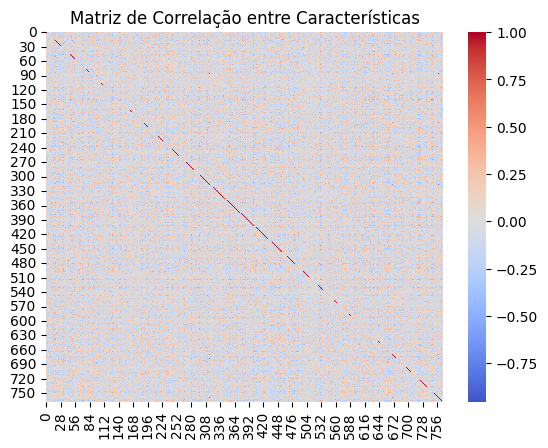

6. Visualizações:


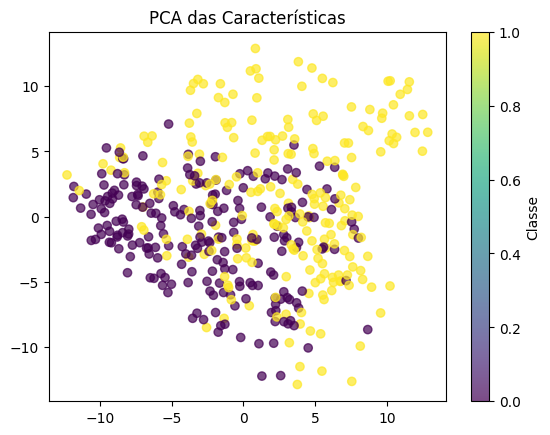

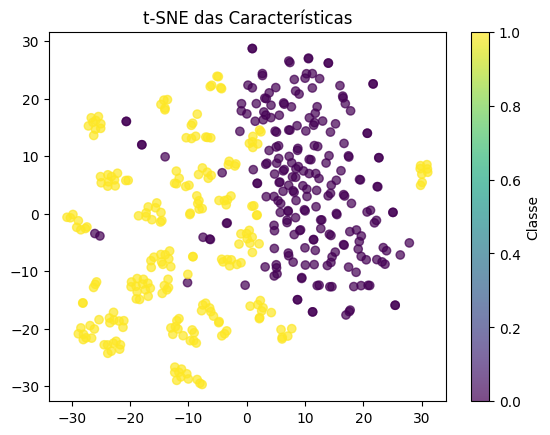

In [152]:
# Métricas finais
print("\nMétricas Finais:")

#from evaluator import FeatureEvaluator
evaluator = FeatureEvaluator(features_train, labels_train)
evaluator.generate_report()

# Dados de teste

In [ ]:
features_test = factory.extract_and_save(extractor, X_test, y_test, 'test_features.npz')